In [ ]:
from fastai2.data.all import *
from nbdev.showdoc import show_doc

# Data block examples

> Examples for computer vision, NLP, and tabular

## Image classification

In [ ]:
from fastai2.vision.all import *

### MNIST

In [ ]:
torch.set_printoptions(threshold=400, linewidth=120)

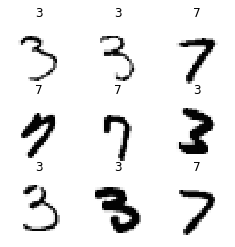

In [ ]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jhoward/.fastai/data/mnist_tiny/train/7/723.png
    applying PILBase.create gives
      <fastai2.vision.core.PILImageBW image mode=L size=28x28 at 0x7F936B6B8290>
  Pipeline: parent_label -> Categorize
    starting from
      /home/jhoward/.fastai/data/mnist_tiny/train/7/723.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (<fastai2.vision.core.PILImageBW image mode=L size=28x28 at 0x7F9366C06BD0>, TensorCategory(1))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (<fastai2.vision.core.PILImageBW im

### Pets

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

### Multi-label - Planet

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

In [ ]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=planet_source/"train", suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

In [ ]:
dls = planet.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = planet.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items,
                   splitter = RandomSplitter(),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

In [ ]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = lambda o:f'{planet_source}/train/'+o.image_name+'.jpg',
                   get_y = lambda o:o.tags.split(),
                   splitter = RandomSplitter(),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

## Image localization

### Segmentation

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

dls = camvid.dataloaders(untar_data(URLs.CAMVID_TINY)/"images")
dls.show_batch(max_n=9, vmin=1, vmax=30)

### Points

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (biwi_source/'centers.pkl').load()

biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)

### Bounding boxes

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 getters=[noop, lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

In [ ]:
dls = coco.dataloaders(coco_source)
dls.show_batch(max_n=9)

## Text

### Language model

In [ ]:
from fastai2.text.all import *

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_lm = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True),),
                    get_x=attrgetter('text'),
                    splitter=RandomSplitter())

In [ ]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)

In [ ]:
dls.show_batch(max_n=6)

### Text classification

In [ ]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', vocab=dls.vocab), CategoryBlock),
                      get_x=attrgetter('text'),
                      get_y=attrgetter('label'),
                      splitter=RandomSplitter())

In [ ]:
dls = imdb_clas.dataloaders(df, bs=64, seq_len=72)

In [ ]:
dls.show_batch(max_n=2)

## Tabular data TODO

In [ ]:
from fastai2.tabular.core import *

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)

In [ ]:
dls = to.dataloaders()
dls.show_batch()